# Sessa Empirical Estimator 🧪
## Overview & Journal Summary 📄
### The Sessa Empirical Estimator (SEE) 📊
Sometimes, it is difficult to track prescriptions especially when in the secondary data source there are missing or incomplete dosing details. This is where the SEE comes in. The SEE was introduced as a data-driven method for computing the duration of prescriptions from secondary data sources. The following are the main steps that SEE does.

1. **Compute Temporal Distances**: For each patient, calculate the time between consecutive prescription fills.
2. **Trim Outliers**: Use the empirical cumulative distribution function (ECDF) to remove the top 20% of these distances (which may be inflated by irregular refill patterns).
3. **Random Sampling & Standardization**: Randomly select pairs of consecutive fills, then standardize these temporal distances.
4. **Clustering**: Use k‑means clustering (with the optimal number of clusters determined, for example, via silhouette analysis) to group the standardized distances.
5. **Duration Estimation**: For each cluster, compute the median temporal distance to serve as the estimated “filled‐prescription duration.”

The journals we read had reports of high accuracy and sensitivity when validating the method on both simulated and real-world data. We will now try to replicate the R code of these journals into our Python implementations and then use a different clustering method for comparison and analysis of results.

## Importing the necessary libraries


In [1]:
pip install numpy pandas scikit-learn matplotlib seaborn lifelines

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')

## Converting R Code to Python 🔄
Below is a simplified Python implementation of the SEE method using common packages like pandas, numpy, and scikit-learn

### Simulating a Dataset
After this step, customer_features data frame is created where each row is a customer and the columns include the features that we want to visualize.

In [12]:
#######################
# 1. Simulate Data
#######################
np.random.seed(42)

def simulate_patient_data(num_patients):
    rows_per_patient = np.random.randint(2, 10, size=num_patients)  # each patient has 2-9 events
    records = []
    for p in range(num_patients):
        pnr = p + 1
        # random starting date
        base_date = pd.Timestamp('2020-01-01') + pd.Timedelta(days=np.random.randint(0, 100))
        # create a series of 2-9 events
        dates = [base_date]
        for i in range(rows_per_patient[p] - 1):
            gap_days = np.random.randint(10, 350)  # random interval
            new_date = dates[-1] + pd.Timedelta(days=gap_days)
            dates.append(new_date)
        for d in dates:
            records.append((pnr, d))
    return records

# Simulate data for 100 patients
records_set = simulate_patient_data(100)

# Create a single dataframe
df = pd.DataFrame(records_set, columns=['pnr', 'eksd'])
df = df.sort_values(by=['pnr', 'eksd']).reset_index(drop=True)

# Randomly assign each row to either 'medA' or 'medB'
df['ATC'] = np.random.choice(['medA', 'medB'], size=len(df))

# Print the records for verification
print("Records Set:")
print(df)


Records Set:
     pnr       eksd   ATC
0      1 2020-03-03  medA
1      1 2020-10-16  medA
2      1 2020-12-08  medB
3      1 2021-05-28  medB
4      1 2021-12-25  medA
..   ...        ...   ...
555  100 2020-08-14  medA
556  100 2020-10-20  medA
557  100 2021-03-26  medB
558  100 2022-02-15  medA
559  100 2022-02-25  medA

[560 rows x 3 columns]


### Clustering and Visualization
Once the multiple numeric columns (e.g., total_spend, total_invoices, avg_spend_per_invoice, total_items, avg_days_diff) is made, we then start to cluster each in a multi‑dimensional space and then reduce to 2D representation for a nice cluster plot visualization.

     pnr       eksd   ATC  prev_eksd  event.interval  cluster  median  \
1      1 2021-12-25  medA 2020-10-16           435.0     -1.0   214.0   
2      1 2022-09-30  medA 2021-12-25           279.0      1.0   214.0   
3      1 2024-05-15  medA 2022-09-30           593.0     -1.0   214.0   
5      2 2022-11-26  medA 2021-07-10           504.0     -1.0   214.0   
8      4 2021-05-27  medA 2020-09-08           261.0      1.0   214.0   
..   ...        ...   ...        ...             ...      ...     ...   
185   96 2022-10-11  medA 2022-05-10           154.0      1.0   214.0   
186   96 2023-09-12  medA 2022-10-11           336.0      1.0   214.0   
187   96 2024-04-25  medA 2023-09-12           226.0      1.0   214.0   
191  100 2022-02-15  medA 2020-10-20           483.0     -1.0   214.0   
192  100 2022-02-25  medA 2022-02-15            10.0      0.0    48.0   

     Duration  P Number  
1         435         1  
2         279         2  
3         593         3  
5         504      

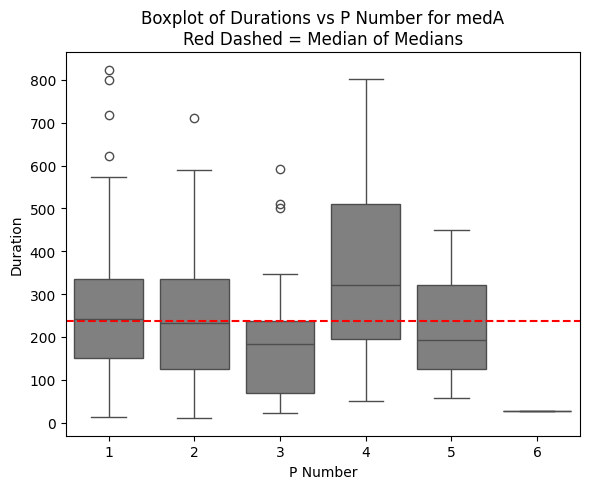

     pnr       eksd   ATC  prev_eksd  event.interval  cluster  median  \
1      1 2023-08-09  medB 2021-05-28           803.0     -1.0   250.0   
4      3 2021-07-01  medB 2020-10-28           246.0      1.0   250.0   
5      3 2022-08-14  medB 2021-07-01           409.0      1.0   250.0   
7      4 2023-06-13  medB 2022-01-29           500.0     -1.0   250.0   
9      6 2022-11-23  medB 2020-08-15           830.0     -1.0   250.0   
..   ...        ...   ...        ...             ...      ...     ...   
170   95 2022-06-12  medB 2021-04-09           429.0     -1.0   250.0   
174   98 2022-09-08  medB 2020-11-26           651.0     -1.0   250.0   
176   99 2021-01-12  medB 2020-11-25            48.0      0.0    69.0   
177   99 2021-11-25  medB 2021-01-12           317.0      1.0   250.0   
178   99 2022-04-24  medB 2021-11-25           150.0      1.0   250.0   

     Duration  P Number  
1         803         1  
4         246         1  
5         409         2  
7         500      

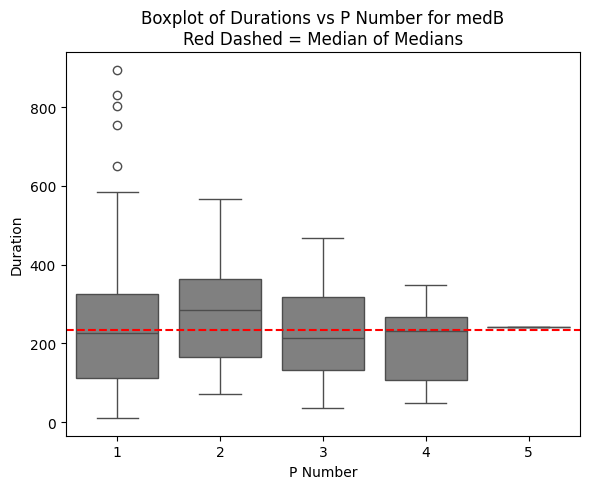

In [18]:
#######################
# 2. Define the "See" Function in Python
#######################
def See_py(data, atc_code='medA'):
    # Filter by ATC code
    df_sub = data[data['ATC'] == atc_code].copy()
    
    # Sort by pnr, eksd and compute event.interval
    df_sub = df_sub.sort_values(by=['pnr','eksd'])
    df_sub['prev_eksd'] = df_sub.groupby('pnr')['eksd'].shift(1)
    # drop rows where there's no previous date
    df_sub = df_sub.dropna(subset=['prev_eksd'])
    
    df_sub['event.interval'] = (df_sub['eksd'] - df_sub['prev_eksd']).dt.days.astype(float)
    
    # 2a. Build empirical distribution
    sorted_intervals = np.sort(df_sub['event.interval'].values)
    # compute empirical CDF
    cdf_vals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    
    # 2b. Keep intervals <= 80th percentile (top 20% truncated)
    cutoff_index = np.searchsorted(cdf_vals, 0.8)
    cutoff_value = sorted_intervals[cutoff_index] if cutoff_index < len(sorted_intervals) else sorted_intervals[-1]
    
    df_trunc = df_sub[df_sub['event.interval'] <= cutoff_value].copy()
    
    # 2c. K-means Clustering with Silhouette-based K selection
    # We'll cluster log(event.interval)
    intervals_log = np.log(df_trunc['event.interval'].values.reshape(-1,1))
    # scale for numeric stability
    intervals_scaled = scale(intervals_log)
    
    possible_ks = range(2,6)  # try k=2..5
    best_k = 2
    best_sil = -999
    for k in possible_ks:
        km = KMeans(n_clusters=k, random_state=123).fit(intervals_scaled)
        labels = km.labels_
        sil = silhouette_score(intervals_scaled, labels)
        if sil > best_sil:
            best_sil = sil
            best_k = k
    
    # run final K-means with best_k
    final_km = KMeans(n_clusters=best_k, random_state=123).fit(intervals_scaled)
    df_trunc['cluster'] = final_km.labels_
    
    # 2d. For each cluster, find min, max, median on the exponentiated scale
    # we can do this by grouping
    cluster_stats = df_trunc.groupby('cluster')['event.interval'].agg(['min','max','median']).reset_index()
    
    # Merge cluster stats back to the truncated df
    df_trunc = df_trunc.merge(cluster_stats, on='cluster', how='left', suffixes=('','_clust'))
    
    # 2e. Now map cluster stats to the entire original subset
    # For any row in the original subset not in df_trunc, we assign the "most frequent cluster's median"
    freq_cluster = df_trunc['cluster'].value_counts().idxmax()
    fallback_median = cluster_stats.loc[cluster_stats['cluster']==freq_cluster,'median'].values[0]
    
    # Merge cluster info back
    df_merged = df_sub.merge(df_trunc[['pnr','eksd','cluster','median']], on=['pnr','eksd'], how='left')
    
    # Fill missing cluster/median with fallback
    df_merged['cluster'] = df_merged['cluster'].fillna(-1)
    df_merged['median'] = df_merged['median'].fillna(fallback_median)
    
    # Return final
    return df_merged

#######################
# 3. "see_assumption" in Python: Boxplot of intervals vs. p_number
#######################
def see_assumption_py(data):
    # Sort by pnr, eksd and compute a 'p_number' index
    df_temp = data.copy()
    df_temp = df_temp.sort_values(by=['pnr','eksd'])
    df_temp['prev_eksd'] = df_temp.groupby('pnr')['eksd'].shift(1)
    df_temp.dropna(subset=['prev_eksd'], inplace=True)
    df_temp['Duration'] = (df_temp['eksd'] - df_temp['prev_eksd']).dt.days
    
    # Within each pnr, create a sequence
    df_temp['P Number'] = df_temp.groupby('pnr').cumcount() + 1
    print(df_temp)
    
    # Boxplot
    fig, ax = plt.subplots(figsize=(6,5))
    sns.boxplot(data=df_temp, x='P Number', y='Duration',ax=ax, color='gray')
    
    # Compute "median of medians"
    medians_of_medians = df_temp.groupby('pnr')['Duration'].median().median()
    
    # Horizontal red dashed line
    ax.axhline(medians_of_medians, color='red', linestyle='--')
    atc_code = data['ATC'].iloc[0]
    ax.set_title(f"Boxplot of Durations vs P Number for {atc_code}\nRed Dashed = Median of Medians")
    plt.tight_layout()
    plt.show()

#######################
# 4. Run the functions with "medA" and "medB"
#######################
df_clustered = See_py(df)
see_assumption_py(df_clustered)

df_clustered = See_py(df, "medB")
see_assumption_py(df_clustered)

## Insights for the Sessa K Means Model 📈
The data used in this case is from Online Retail II of UC Irvine Machine Learning Repository. It has all transactions happening for a UK-based and registered online retail from December 1, 2009 to December 9, 2011. They mainly sell unique all-occasion gifts.

## Substituting K-Means with an Alternative Clustering Algorithm 🔄
K-means has well-known disadvantages—it assumes clusters are spherical, it needs to predetermine the number of clusters, and is very sensitive to outliers. To overcome these issues, you could try using DBSCAN, which can automatically identify the number of clusters and detect noise.

In [ ]:
from sklearn.cluster import DBSCAN

# Use DBSCAN on the standardized data
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(X)

# Filter out noise points (label = -1)
mask = labels_db != -1
X_db = X[mask]
labels_db = labels_db[mask]

# Create a DataFrame for DBSCAN results
db_df = pd.DataFrame({
    'days_diff': trimmed_diffs[mask],
    'cluster': labels_db
})

# Compute median durations for each DBSCAN cluster
db_cluster_medians = db_df.groupby('cluster')['days_diff'].median()
print("Median durations by DBSCAN cluster:")
print(db_cluster_medians)

# Visualize the clustering results
plt.scatter(X, np.zeros_like(X), c=labels_db, cmap='viridis')
plt.xlabel('Standardized Temporal Difference')
plt.title('DBSCAN Clustering of Temporal Differences')
plt.show()